In [202]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Load the data
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'NSL_regular_season_data_2.csv')
print(data_path)
data = pd.read_csv(data_path)

/workspaces/Wharton-HS-Competition-Soccer-Playoff-Predictions/data/NSL_regular_season_data_2.csv


In [203]:
# Visualize the data
data

,game_id,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP
0,game_2023_94,TUC,ALB,1,3,2.52,2.00,13,15,3,4,0,0,1,0,0.53
1,game_2023_341,MOB,ALB,3,1,0.46,0.99,11,8,3,6,0,0,0,0,0.56
2,game_2023_442,CHM,ALB,0,1,1.62,1.16,16,13,1,7,0,0,0,0,0.52
3,game_2023_50,SAS,ALB,2,1,1.53,0.55,20,2,6,1,0,0,0,0,0.49
4,game_2023_389,FOR,ALB,0,2,2.15,1.13,18,13,2,0,0,0,0,0,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,game_2023_81,TUC,WIC,2,1,2.72,0.38,16,8,8,2,0,0,0,0,0.33
472,game_2023_36,DOV,WIC,0,2,1.11,1.34,9,13,7,4,0,0,0,0,0.31
473,game_2023_269,SFS,WIC,1,1,2.84,0.30,26,2,8,6,0,0,0,0,0.54
474,game_2023_298,ALB,WIC,2,3,2.61,2.09,12,17,7,4,0,0,0,0,0.43


In [204]:
# Create a new column called 'Winner' that contains 1 if team wins, 0 if team loses. If tie, use expected goals to determine winner.
data['Winner'] = np.where(data['HomeScore'] > data['AwayScore'], 1, 0)
data['Winner'] = np.where(data['HomeScore'] < data['AwayScore'], 0, data['Winner'])
data['Winner'] = np.where(data['HomeScore'] == data['AwayScore'], np.where(data['Home_xG'] > data['Away_xG'], 1, 0), data['Winner'])
data['Winner'] = data['Winner'].astype(int)

# Create a date column from the matches.
data['GameNumber'] = data['game_id'].str.split('_', expand=True)[2]
data['GameNumber'] = data['GameNumber'].astype(int)
data.drop('game_id', axis=1, inplace=True)
data.sort_values(by='GameNumber', inplace=True)
data.reset_index(drop=True, inplace=True)

data

,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP,Winner,GameNumber
0,PRO,MAN,1,1,1.63,0.34,17,8,5,4,0,0,0,0,0.53,1,1
1,FOR,LEX,1,0,0.98,0.90,9,11,5,2,0,0,0,0,0.57,1,2
2,SJU,DES,1,2,1.23,1.11,16,9,6,7,0,0,0,0,0.47,0,3
3,FAR,ANC,0,1,2.27,1.08,4,14,8,3,0,0,0,0,0.51,0,4
4,DOV,BAK,0,0,1.90,0.56,17,6,5,3,0,0,0,0,0.53,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,SAS,TAC,1,2,0.71,0.51,19,12,7,7,0,0,0,0,0.42,0,472
472,DOV,MOB,1,1,1.70,0.14,19,10,1,5,0,0,0,0,0.51,1,473
473,BAK,EUG,3,2,2.68,1.43,17,18,9,6,1,0,2,1,0.49,1,474
474,LRO,LEX,1,2,2.10,1.30,17,6,5,5,0,0,0,0,0.51,0,475


In [205]:
team_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'data', 'NSL_Metadata.csv'))
team_data.head()

,name,city,state,Team_ID,conference,timezone_UTC,Unnamed: 6
0,Albuquerque Scorpions FC,Albuquerque,New Mexico,ALB,Western,-6,NaN
1,Anchorage Avalanche FC,Anchorage,Alaska,ANC,Western,-8,NaN
2,Augusta Arrows FC,Augusta,Georgia,AUG,Eastern,-4,NaN
3,Bakersfield Bandits FC,Bakersfield,California,BAK,Western,-7,NaN
4,Boise Thunderhawks FC,Boise,Idaho,BOI,Western,-6,NaN


In [206]:
# Perform one-hot encoding on the 'HomeTeam' and 'AwayTeam' columns.
# If the team is the home team, the column will be 2, else 1.
# for team in team_data['Team_ID']:
#     data[team] = (data['HomeTeam'] == team) * 2 + (data['AwayTeam'] == team)
#     data[team] = data[team].astype(int)

data

,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP,Winner,GameNumber
0,PRO,MAN,1,1,1.63,0.34,17,8,5,4,0,0,0,0,0.53,1,1
1,FOR,LEX,1,0,0.98,0.90,9,11,5,2,0,0,0,0,0.57,1,2
2,SJU,DES,1,2,1.23,1.11,16,9,6,7,0,0,0,0,0.47,0,3
3,FAR,ANC,0,1,2.27,1.08,4,14,8,3,0,0,0,0,0.51,0,4
4,DOV,BAK,0,0,1.90,0.56,17,6,5,3,0,0,0,0,0.53,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,SAS,TAC,1,2,0.71,0.51,19,12,7,7,0,0,0,0,0.42,0,472
472,DOV,MOB,1,1,1.70,0.14,19,10,1,5,0,0,0,0,0.51,1,473
473,BAK,EUG,3,2,2.68,1.43,17,18,9,6,1,0,2,1,0.49,1,474
474,LRO,LEX,1,2,2.10,1.30,17,6,5,5,0,0,0,0,0.51,0,475


Text(0, 0.5, 'Frequency')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

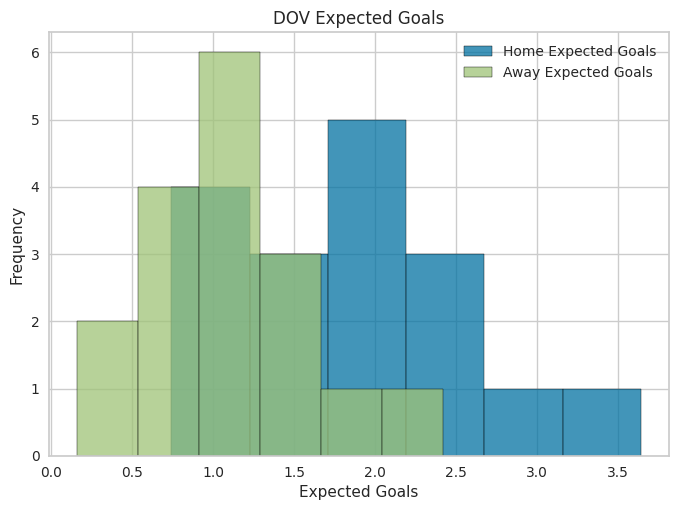

In [207]:
# See if the expected goals for a certain team follows a trend.
rand_team = random.choice(team_data['Team_ID'])
# Make two distributions for the home and away scores
home_scores = data[data['HomeTeam'] == rand_team]['Home_xG']
away_scores = data[data['AwayTeam'] == rand_team]['Away_xG']
# Plot the distributions
sns.histplot(home_scores, label='Home Expected Goals')
sns.histplot(away_scores, label='Away Expected Goals')
plt.legend(loc=1)
plt.title(f'{rand_team} Expected Goals')
plt.xlabel('Expected Goals')
plt.ylabel('Frequency')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

Text(0.5, 1.0, 'Accuracy: 0.75')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

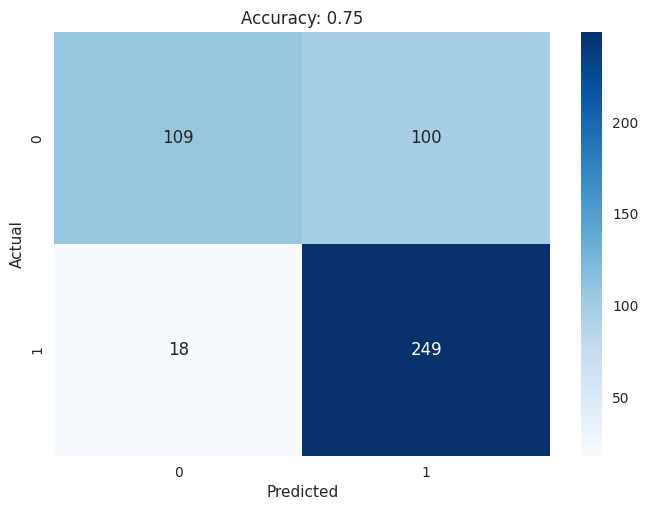

In [208]:
# See how good the expected goals are at predicting the winner of a match.
expected_winner = data['Home_xG'] > data['Away_xG']
winner = data['Winner']

accuracy = (expected_winner == winner).sum() / len(winner)
conf_matrix = confusion_matrix(winner, expected_winner)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Accuracy: {accuracy:.2f}')

,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP,Winner,GameNumber,HomeLastGame,AwayLastGame
0,PRO,MAN,1,1,1.63,0.34,17,8,5,4,0,0,0,0,0.53,1,1,0,0
1,FOR,LEX,1,0,0.98,0.90,9,11,5,2,0,0,0,0,0.57,1,2,0,0
2,SJU,DES,1,2,1.23,1.11,16,9,6,7,0,0,0,0,0.47,0,3,0,0
3,FAR,ANC,0,1,2.27,1.08,4,14,8,3,0,0,0,0,0.51,0,4,0,0
4,DOV,BAK,0,0,1.90,0.56,17,6,5,3,0,0,0,0,0.53,1,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,SAS,TAC,1,2,0.71,0.51,19,12,7,7,0,0,0,0,0.42,0,472,62,55
472,DOV,MOB,1,1,1.70,0.14,19,10,1,5,0,0,0,0,0.51,1,473,58,34
473,BAK,EUG,3,2,2.68,1.43,17,18,9,6,1,0,2,1,0.49,1,474,51,55
474,LRO,LEX,1,2,2.10,1.30,17,6,5,5,0,0,0,0,0.51,0,475,6,14


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

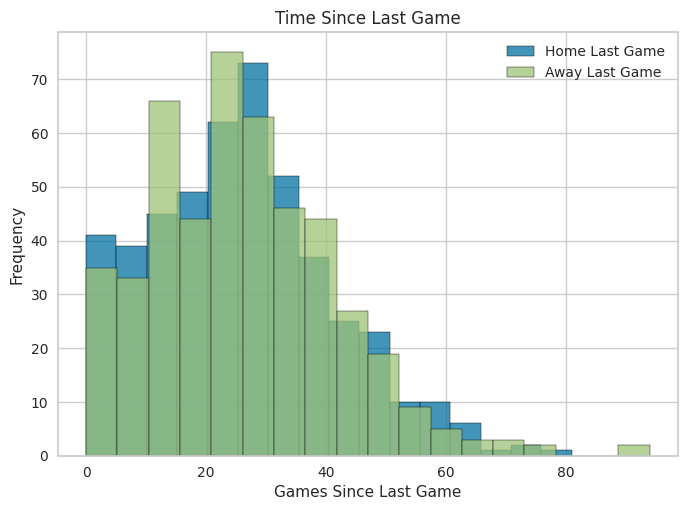

In [209]:
# See if the time since the last game (either as home or away) has an effect on the outcome of the game.
# Create a new column that contains the time since the last game for the home and away teams.
# If the team has not played a game yet, the time since the last game will be 0.
# For each row, the time since the last game will be the difference between the current game number and the previous game number (whether the last game was home or away).
# for game in data['GameNumber']:
#     home_team = data[data['GameNumber'] == game]['HomeTeam'].values[0]
#     away_team = data[data['GameNumber'] == game]['AwayTeam'].values[0]
#     # Find the time since the last game for the home and away teams
#     home_last_games = data[(data['HomeTeam'] == home_team) | (data['AwayTeam'] == home_team)]['GameNumber']
#     away_last_games = data[(data['HomeTeam'] == away_team) | (data['AwayTeam'] == away_team)]['GameNumber']
#     home_last_game = game - home_last_games[home_last_games < game].max() if len(home_last_games[home_last_games < game]) > 0 else 0
#     away_last_game = game - away_last_games[away_last_games < game].max() if len(away_last_games[away_last_games < game]) > 0 else 0
#     data.loc[data['GameNumber'] == game, 'HomeLastGame'] = home_last_game # Last Time Home Team Played at all
#     data.loc[data['GameNumber'] == game, 'AwayLastGame'] = away_last_game # Last Time Away Team Played at all

data['HomeLastGame'] = data.groupby('HomeTeam')['GameNumber'].diff().fillna(0) # Last Time Home Team Played as Home Team
data['AwayLastGame'] = data.groupby('AwayTeam')['GameNumber'].diff().fillna(0) # Last Time Away Team Played as Away Team
data['HomeLastGame'] = data['HomeLastGame'].astype(int)
data['AwayLastGame'] = data['AwayLastGame'].astype(int)

# Plot the distributions of the time since the last game for the home and away teams.
sns.histplot(data['HomeLastGame'], label='Home Last Game')
sns.histplot(data['AwayLastGame'], label='Away Last Game')
plt.legend(loc=1)
plt.title('Time Since Last Game')
plt.xlabel('Games Since Last Game')
plt.ylabel('Frequency')

data

In [210]:
# Does morale (current win streak) have an effect on the outcome of the game?
# Create a new column that contains the current win streak for the home and away teams.
# Reset the win streak for each team when the team loses.
data['HomeWins'] = -1
data['AwayWins'] = -1
home_win_streaks = []
away_win_streaks = []

for game in data['GameNumber']:
    print('Game Number', game)
    home_team = data[data['GameNumber'] == game]['HomeTeam'].values[0]
    away_team = data[data['GameNumber'] == game]['AwayTeam'].values[0]
    # Find the current win streak for the home and away teams
    home_games_for_home = data[(data['HomeTeam'] == home_team) & (data['GameNumber'] < game)]['Winner']
    away_games_for_home = 1 - data[(data['AwayTeam'] == home_team) & (data['GameNumber'] < game)]['Winner']
    home_wins_for_home = home_games_for_home.sum()
    away_wins_for_home = away_games_for_home.sum()

    home_games_for_away = data[(data['HomeTeam'] == away_team) & (data['GameNumber'] < game)]['Winner']
    away_games_for_away = 1 - data[(data['AwayTeam'] == away_team) & (data['GameNumber'] < game)]['Winner']
    home_wins_for_away = home_games_for_away.sum()
    away_wins_for_away = away_games_for_away.sum()
    data.loc[data['GameNumber'] == game, 'HomeWins'] = home_wins_for_home + away_wins_for_home
    data.loc[data['GameNumber'] == game, 'AwayWins'] = home_wins_for_away + away_wins_for_away
    # Reset the win streak for each team when the team loses
    games_for_home = home_games_for_home.append(away_games_for_home)
    games_for_away = home_games_for_away.append(away_games_for_away)
    # Sort the games in descending order
    games_for_home.sort_index(ascending=False, inplace=True)
    games_for_away.sort_index(ascending=False, inplace=True)
    # Find the current win streak for the home and away teams
    home_win_streak = 0
    away_win_streak = 0
    for game in games_for_home:
        if game:
            home_win_streak += 1
            print(home_win_streak)
        else:
            print('Done Home', home_win_streak)
            break
    for game in games_for_away:
        if game:
            away_win_streak += 1
            print(away_win_streak)
        else:
            print('Done Away', away_win_streak)
            break
    home_win_streaks.append(home_win_streak)
    away_win_streaks.append(away_win_streak)
    print()

data['HomeWinStreak'] = home_win_streaks
data['AwayWinStreak'] = away_win_streaks

data['HomeWins'] = data['HomeWins'].astype(int)
data['AwayWins'] = data['AwayWins'].astype(int)
data['HomeWinStreak'] = data['HomeWinStreak'].astype(int)
data['AwayWinStreak'] = data['AwayWinStreak'].astype(int)

data

Game Number 1

Game Number 2

Game Number 3

Game Number 4

Game Number 5

Game Number 6



Game Number 7

Game Number 8

Game Number 9

Game Number 10

Game Number 11

Game Number 12

Game Number 13

Game Number 14
1
1

Game Number 15
1

Game Number 16
1
1

Game Number 17
Done Home 0
Done Away 0

Game Number 18
Done Home 0
Done Away 0

Game Number 19
1
1

Game Number 20
Done Home 0
Done Away 0

Game Number 21
Done Home 0
Done Away 0

Game Number 22
Done Home 0
Done Away 0

Game Number 23
1
1

Game Number 24
Done Home 0

Game Number 25
1
1

Game Number 26
1
1

Game Number 27
Done Home 0
Done Away 0

Game Number 28
Done Home 0
Done Away 0

Game Number 29
Done Home 0
1
Done Away 1

Game Number 30
Done Home 0
1
Done Away 1

Game Number 31
Done Home 0
Done Away 0

Game Number 32
1
2
1
Done Away 1

Game Number 33
Done Home 0
Done Away 0

Game Number 34
Done Home 0
1
Done Away 1

Game Number 35
1
2
1
2

Game Number 36
1
2
1

Game Number 37
1
2
Done Away 0

Game Number 38
Done Home 0
1
Done Away 1

Game Number 39
1
Done Home 1
1
Done Away 1

Game Number 40
Done Home 0
1
2

Game Num

,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,...,Away_PK_shots,Home_ToP,Winner,GameNumber,HomeLastGame,AwayLastGame,HomeWins,AwayWins,HomeWinStreak,AwayWinStreak
0,PRO,MAN,1,1,1.63,0.34,17,8,5,4,...,0,0.53,1,1,0,0,0,0,0,0
1,FOR,LEX,1,0,0.98,0.90,9,11,5,2,...,0,0.57,1,2,0,0,0,0,0,0
2,SJU,DES,1,2,1.23,1.11,16,9,6,7,...,0,0.47,0,3,0,0,0,0,0,0
3,FAR,ANC,0,1,2.27,1.08,4,14,8,3,...,0,0.51,0,4,0,0,0,0,0,0
4,DOV,BAK,0,0,1.90,0.56,17,6,5,3,...,0,0.53,1,5,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,SAS,TAC,1,2,0.71,0.51,19,12,7,7,...,0,0.42,0,472,62,55,20,6,1,0
472,DOV,MOB,1,1,1.70,0.14,19,10,1,5,...,0,0.51,1,473,58,34,18,15,0,0
473,BAK,EUG,3,2,2.68,1.43,17,18,9,6,...,1,0.49,1,474,51,55,14,13,1,0
474,LRO,LEX,1,2,2.10,1.30,17,6,5,5,...,0,0.51,0,475,6,14,20,17,0,0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

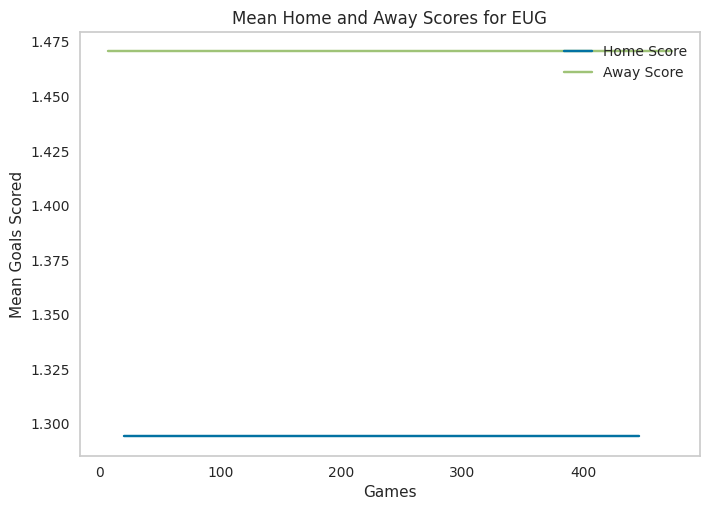

In [211]:
# Target encode the scores. Average number of goals scored by the home team and away team.
# If the means for the same team for home and away are different, then being at home or away has an effect on the score.
data['HomeScore'] = data.groupby('HomeTeam')['HomeScore'].transform('mean')
data['AwayScore'] = data.groupby('AwayTeam')['AwayScore'].transform('mean')

# Compare the means of the scores for the home and away teams
rand_team = random.choice(team_data['Team_ID'])
plt.plot(data[data['HomeTeam'] == rand_team]['HomeScore'], label='Home Score')
plt.plot(data[data['AwayTeam'] == rand_team]['AwayScore'], label='Away Score')
plt.xlabel('Games')
plt.ylabel('Mean Goals Scored')
plt.grid()
plt.title(f'Mean Home and Away Scores for {rand_team}')
plt.legend(loc=1)


In [212]:
# Drop the 'HomeTeam' and 'AwayTeam' columns
# data.drop(['HomeTeam', 'AwayTeam'], axis=1, inplace=True)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

<AxesSubplot: >

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

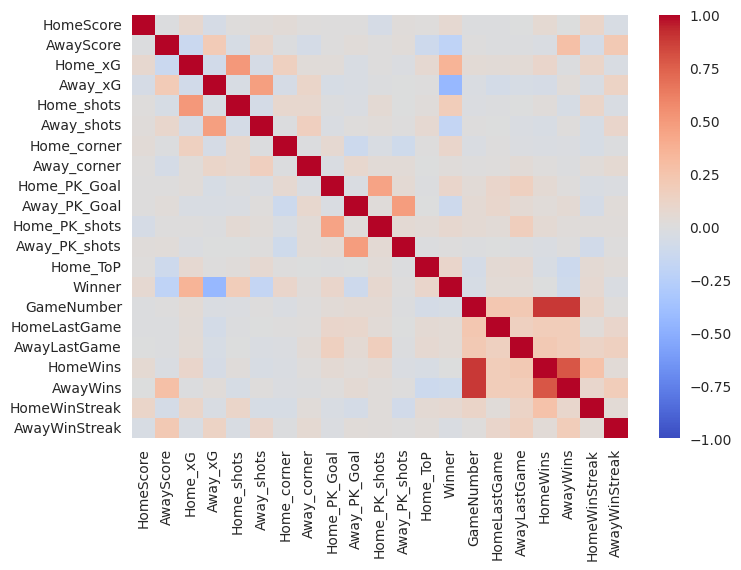

In [213]:
# Find what features are most correlated with the winner
corr = data.corr()

# Create a heatmap
# Set the colorbar limits to be between -1 and 1
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)

In [214]:
from pycaret.classification import ClassificationExperiment
s = ClassificationExperiment()
s.setup(data, target = 'Winner', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Winner
2,Target type,Binary
3,Original data shape,"(476, 23)"
4,Transformed data shape,"(476, 23)"
5,Transformed train set shape,"(333, 23)"
6,Transformed test set shape,"(143, 23)"
7,Numeric features,20
8,Categorical features,2
9,Preprocess,True


In [215]:
best = s.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7357,0.8021,0.7760,0.7616,0.7661,0.4617,0.4668,0.1810
ridge,Ridge Classifier,0.7301,0.0000,0.7760,0.7540,0.7632,0.4489,0.4523,0.0610
rf,Random Forest Classifier,0.7119,0.7569,0.7915,0.7253,0.7545,0.4059,0.4134,0.2280
lda,Linear Discriminant Analysis,0.7057,0.7571,0.7544,0.7352,0.7437,0.3981,0.3995,0.1010
et,Extra Trees Classifier,0.6996,0.7445,0.7810,0.7154,0.7447,0.3803,0.3864,0.1960
lightgbm,Light Gradient Boosting Machine,0.6907,0.7303,0.7436,0.7195,0.7288,0.3683,0.3722,0.2190
gbc,Gradient Boosting Classifier,0.6848,0.7492,0.7173,0.7217,0.7175,0.3609,0.3643,0.1800
ada,Ada Boost Classifier,0.6669,0.7328,0.6915,0.7173,0.7008,0.3248,0.3294,0.1230
dt,Decision Tree Classifier,0.6247,0.6157,0.6909,0.6622,0.6737,0.2317,0.2346,0.0560
nb,Naive Bayes,0.6186,0.7475,0.9684,0.6005,0.7407,0.1517,0.2388,0.0590


In [216]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…